# Teched 2022 - DA180 Session - Exercise 6

## Multi Model ML Scenario
### Problem statement
Create a machine learning model to forecast the fuel prices for the service stations in the Rhein-Neckar district based on 
the tanker König dataset.
### Dataset
The dataset is published on the public website “Tankerkönig“ (http://www.tankerkoenig.de/). This dataset contains the gas prices of all gas stations in Germany from 2014 until today as csv files. A record contains the station id, the datetime, prices for diesel, e5 and e10 and a change indicator. In a separate csv the data of the service stations including its geolocation is provided. 

We use the stations and prices data within this website only for blog posting and demonstration
purpose. For non-commercial use the data is availble with the following license agreement (https://creativecommons.org/licenses/by-nc-sa/4.0/)
Data download from https://dev.azure.com/tankerkoenig/_git/tankerkoenig-data?path=/prices/2022

## Setup and connection

### Import the requied python packages

In [352]:
import hana_ml
print(hana_ml.__version__)
from hana_ml import dataframe
from hana_ml.dataframe import create_dataframe_from_pandas, create_dataframe_from_shapefile
from hana_ml.algorithms.pal.tsa.additive_model_forecast import AdditiveModelForecast
from hana_ml.algorithms.pal import metrics
from hdbcli import dbapi
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import descartes



2.14.22091801


In [359]:
#pip freeze
#requirements txt
#pip install damit

### Connect to hana database

In [ ]:
host = '[YourHostName]'
port = 443
user = '[YourUser]'
passwd = '[YourUserPassword]'

In [3]:
#conn = dataframe.ConnectionContext(url, port, user, pwd)
conn= dataframe.ConnectionContext(address=host, port=port, user=user, password=passwd,
                               encrypt='true' ,sslValidateCertificate='false')

In [353]:
#conn = dataframe.ConnectionContext( address="<machine>", port=<SQL-port>,  user="<HANA-user>", password="<password>")
hc_url = '859c0f95-60f9-4540-aa81-581a8e452c6f.hna1.canary-eu10.hanacloud.ondemand.com'
conn = dataframe.ConnectionContext( address=hc_url, port=443, user="TECHED_USER_999", password='TechEd22Welcome' )
conn.hana_version()

'4.00.000.00.1663064250 (fa/CE2022.30)'

# EX1 Data preparation, Load datasets

Clone data from https://github.com/SAP-samples/teched2022-DA180/tree/main/data/fuelprice

In [3]:
#!dir fuelprice
!dir datasets

 Volume in drive C is OSDisk
 Volume Serial Number is 72BC-6B0D

 Directory of C:\Users\D059078\OneDrive - SAP SE\Documents\D059078_Docs\_Projekte\python\PythonNotebooks\##events\#22TE\FuelPriceForecast\datasets

02.10.2022  09:39    <DIR>          .
02.10.2022  09:39    <DIR>          ..
14.09.2022  16:33         3,720,892 AX_Gebiet_Kreis.shp
02.10.2022  09:39    <DIR>          georef-germany-kreis
05.10.2022  11:21           818,730 georef-germany-kreis-millesime.dbf
05.10.2022  11:21         6,810,700 georef-germany-kreis-millesime.shp
02.10.2022  09:32         5,542,990 georef-germany-kreis.zip
22.09.2022  10:18    <DIR>          OD_AX_Gebiet_Kreis
14.09.2022  16:33         1,896,433 stations.csv
14.09.2022  16:33         1,242,543 test_groundtruth.csv
14.09.2022  16:33         1,206,725 test_rnk.csv
14.09.2022  16:33        25,064,170 train_rnk.csv
               8 File(s)     46,303,183 bytes
               4 Dir(s)  449,718,611,968 bytes free


# Ex 4 Model Tanke-Klassifikation
## 4.1 Prepare klass data

In [299]:
# 1 station master data
#print("There are", stations_hdf.count(), "service stations in Germany")
#display(stations_hdf.head(5).collect())
station_master=stations_hdf.select('uuid', 'brand', 'post_code', ('substr("post_code",1,2)', 'post_code2'), 'city')
display(station_master.head(3).collect())

uuid  brand post_code post_code2  \
0  064554c1-d960-444e-bc1b-0a0449711e44  Shell     10585         10   
1  0ba0e8ac-ae93-4a29-837c-165bfa0fac2f   ARAL     74199         74   
2  2020d9be-d9db-456f-9bd1-c72f3ad5d279   ARAL     12103         12   

               city  
0            BERLIN  
1  Untergruppenbach  
2            Berlin

In [288]:
# 2 station classification data
stations_class=conn.sql(
"""
SELECT "station_uuid", E5_AVG, BINNING(VALUE => E5_AVG, BIN_COUNT => 10) OVER () AS STATION_CLASS 
  FROM ( SELECT  "station_uuid",  avg("e5") AS E5_AVG 
         FROM (  SELECT "date", DAY, HOUR, "station_uuid", "e5" 
                 FROM  RAW_DATA.GAS_PRICES_ANALYSIS 
                 WHERE  "e5" > 1.3 AND "e5" < 2.8)
         GROUP BY "station_uuid" 
         HAVING COUNT("e5")>20);
"""
)
stations_class.collect()

station_uuid    E5_AVG  STATION_CLASS
0      00006210-0037-4444-8888-acdc00006210  1.948780              4
1      00016899-3247-4444-8888-acdc00000007  1.992414              5
2      00041414-208c-4444-8888-acdc00000414  2.016500              5
3      00041450-0002-4444-8888-acdc00000002  1.931636              4
4      00047369-0001-4444-8888-acdc00000001  1.962834              4
...                                     ...       ...            ...
14823  ffe9d976-9a40-43aa-915b-b0eb25bbc541  1.977396              4
14824  fff05f62-7e1e-42e4-8d71-6e2c9c963a8b  2.417659             10
14825  fff261ef-ff00-4d2b-8669-ec2f7c57cd93  2.054457              5
14826  fffb0617-e77d-48dd-838c-f43a945f6f70  1.973917              4
14827  fffd3828-c4e3-1035-8eef-40618651be9a  1.938178              4

[14828 rows x 3 columns]

In [269]:
# 3 station classification data
stations_price_indicators=conn.sql(
"""
SELECT "station_uuid", 
        /* Daily E5 change related indicators */
        SUM(CAST("N_E5C_D" as DOUBLE)) AS SUM_E5C, MIN(CAST("N_E5C_D" as DOUBLE)) AS MIN_E5C, MAX(CAST("N_E5C_D" as DOUBLE)) AS MAX_E5C, AVG("N_E5C_D") AS AVG_E5C, 
        STDDEV("N_E5C_D") AS STDEV_E5C, MAX(CAST("N_E5C_D" as DOUBLE))-MIN(CAST("N_E5C_D" as DOUBLE)) AS RANGE_E5C,
        /* Daily E5 price related indicators */
        AVG("VAR_E5_D") AS AVG_E5_VAR,  AVG("STDDEV_E5_D") AS AVG_E5_STD,  AVG("MIN_E5_D") AS AVG_E5_MIN,  
        AVG("MAX_E5_D") AS AVG_E5_MAX, SUM("RANGE_E5_D") AS SUM_E5_RANGE,  AVG("RANGE_E5_D") AS AVG_E5_RANGE 
    FROM (
          SELECT "station_uuid", DAY,  
                /* Daily price analysis indicators */
                count("e5change") AS N_E5C_D, VAR("e5") AS VAR_E5_D,  STDDEV("e5") AS STDDEV_E5_D,  MIN("e5") AS MIN_E5_D, 
                MAX("e5") AS MAX_E5_D, AVG("e5") AS AVG_E5_D, MAX("e5")-MIN("e5") AS RANGE_E5_D
          FROM (
                  SELECT "date", DAY, HOUR, "station_uuid", "e5", "e5change" 
                  FROM  RAW_DATA.GAS_PRICES_ANALYSIS 
                  WHERE  "e5" > 1.3 AND "e5" < 2.8)
          GROUP BY "station_uuid", DAY)
    GROUP BY "station_uuid";
"""
)
stations_price_indicators.head(3).collect()

station_uuid  SUM_E5C  MIN_E5C  MAX_E5C    AVG_E5C  \
0  00006210-0037-4444-8888-acdc00006210   4455.0     10.0     38.0  25.901162   
1  00016899-3247-4444-8888-acdc00000007    905.0      1.0     14.0   6.033333   
2  00041414-208c-4444-8888-acdc00000414     72.0      1.0      4.0   1.220338   

  STDEV_E5C  RANGE_E5C  AVG_E5_VAR  AVG_E5_STD  AVG_E5_MIN  AVG_E5_MAX  \
0  5.267865       28.0    0.000894    0.028872    1.897663    2.007081   
1  2.573527       13.0    0.001109    0.029554    1.943933    2.018733   
2   0.55918        3.0    0.000255    0.003244    2.009000    2.014085   

   SUM_E5_RANGE  AVG_E5_RANGE  
0         18.82      0.109419  
1         11.22      0.074800  
2          0.30      0.005085

In [292]:
stations_num=stations_price_indicators.set_index("station_uuid").join(
             stations_class.drop('STATION_CLASS').set_index("station_uuid"))
#stations_num.head(5).collect()

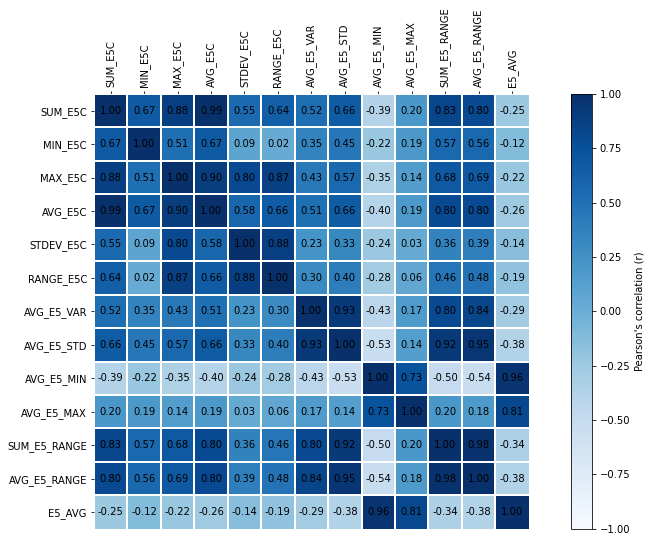

In [293]:
# Avoid usage of intercorrelated indicators, e.g. correlate numerical columns
# join and add AVG
import matplotlib.pyplot as plt
from hana_ml.visualizers.eda import EDAVisualizer
f = plt.figure(figsize=(15, 8))
ax1 = f.add_subplot(111)
eda = EDAVisualizer(ax1)
ax1, corr = eda.correlation_plot(data=stations_num.drop('station_uuid'), cmap="Blues")
plt.show()

In [ ]:
stations_price_indicators=stations_price_indicators.drop('AVG_E5_MIN').drop('AVG_E5_MAX')

In [297]:
stations_price_indicators.head(3).collect()

station_uuid  SUM_E5C  MIN_E5C  MAX_E5C    AVG_E5C  \
0  00006210-0037-4444-8888-acdc00006210   4455.0     10.0     38.0  25.901162   
1  00016899-3247-4444-8888-acdc00000007    905.0      1.0     14.0   6.033333   
2  00041414-208c-4444-8888-acdc00000414     72.0      1.0      4.0   1.220338   

  STDEV_E5C  RANGE_E5C  AVG_E5_VAR  AVG_E5_STD  SUM_E5_RANGE  AVG_E5_RANGE  
0  5.267865       28.0    0.000894    0.028872         18.82      0.109419  
1  2.573527       13.0    0.001109    0.029554         11.22      0.074800  
2   0.55918        3.0    0.000255    0.003244          0.30      0.005085

## 4.2 enrich with spatial attributes 1

distance to next station  
number of stations in cluster  
distance to autobahn, bundestraße, ... - aus OSM ... oder OSMNX (zu fein, da graph und kein linestring für autobahn)

In [285]:
# 4, based on station master data, generate GEOHASH Hierarchy Attributes
stations_spatial_hierarchy = stations_hdf.select('uuid', 'longitude','latitude','longitude_latitude_GEO')
stations_spatial_hierarchy =stations_spatial_hierarchy.generate_feature(targets='longitude_latitude_GEO', 
                                                          trans_func='GEOHASH_HIERARCHY', trans_param=range(3,8))
stations_spatial_hierarchy =stations_spatial_hierarchy.rename_columns({'GEOHASH_HIERARCHY(longitude_latitude_GEO,3)': 'GEO_H3', 
                                                                      'GEOHASH_HIERARCHY(longitude_latitude_GEO,4)': 'GEO_H4', 
                                                                      'GEOHASH_HIERARCHY(longitude_latitude_GEO,5)': 'GEO_H5',
                                                                      'GEOHASH_HIERARCHY(longitude_latitude_GEO,6)': 'GEO_H6',
                                                                      'GEOHASH_HIERARCHY(longitude_latitude_GEO,7)': 'GEO_H7'}
                                                                      )

In [286]:
stations_spatial_hierarchy.head(2).collect()

uuid  longitude   latitude  \
0  064554c1-d960-444e-bc1b-0a0449711e44  13.301201  52.515933   
1  0ba0e8ac-ae93-4a29-837c-165bfa0fac2f   9.275176  49.086426   

        longitude_latitude_GEO GEO_H3 GEO_H4 GEO_H5  GEO_H6   GEO_H7  
0  POINT (13.301201 52.515933)    u33   u336  u336y  u336y8  u336y8j  
1  POINT (9.275176 49.0864258)    u0w   u0wx  u0wx5  u0wx5p  u0wx5pc

In [301]:
stations_spatial = stations_spatial_hierarchy.join(regions_hdf.select('lan_name','krs_name','krs_type','SHAPE'), 
       '"longitude_latitude_GEO".ST_SRID(25832).st_transform(25832).st_intersects(SHAPE)=1')
#'"longitude_latitude_GEO".ST_SRID(25832).st_transform(25832).st_intersects(SHAPE)=1').filter("\"krs_name\"='Landkreis Rhein-Neckar-Kreis'")
stations_spatial.drop('SHAPE').head(5).collect()

uuid  longitude   latitude  \
0  0ec347c7-db46-40df-a7c9-8cf1f1cb12f2   6.657680  51.438660   
1  109195b4-ac2f-4120-ae47-199386e700f6   9.362702  48.788500   
2  1c12bbe1-fc51-48cc-bd6b-f1c08d465f9d   9.122040  49.342990   
3  3aacd52d-f232-4424-9142-ef86a1275032   9.430000  54.119999   
4  72b25af4-8ad9-4944-9fb6-80fc6d383b55  13.256310  53.692330   

                        longitude_latitude_GEO GEO_H3 GEO_H4 GEO_H5  GEO_H6  \
0                     POINT (6.65768 51.43866)    u1h   u1hs  u1hsx  u1hsxk   
1            POINT (9.362702000000001 48.7885)    u0w   u0wt  u0wtt  u0wtt1   
2                     POINT (9.12204 49.34299)    u0y   u0y2  u0y2x  u0y2xw   
3  POINT (9.430000305175801 54.11999893188501)    u1w   u1we  u1wey  u1weys   
4           POINT (13.25631 53.69233000000001)    u39   u393  u393m  u393mw   

    GEO_H7                lan_name                               krs_name  \
0  u1hsxkp     Nordrhein-Westfalen                            Kreis Wesel   
1  u0wtt19       Baden-Württemberg              Landkreis Rems-Murr-Kreis   
2  u0y2xwd       Baden-Württemberg        Landkreis Neckar-Odenwald-Kreis   
3  u1weys4      Schleswig-Holstein            Kreis Rendsburg-Eckernförde   
4  u393mwk  Mecklenburg-Vorpommern  Landkreis Mecklenburgische Seenplatte   

    krs_type  
0      Kreis  
1  Landkreis  
2  Landkreis  
3      Kreis  
4  Landkreis

In [364]:
stations_spatial

In [471]:
stations_hwaydist=conn.sql('select * from RAW_DATA.GAS_STATION_HWAYDIST')
stations_hwaydist.head(5).collect()

uuid  HIGHWAY_DISTANCE
0  e6c55dfa-c64b-44e1-913b-58e216d614e5       2527.323278
1  022c6e51-068e-4acf-a378-80a134829bdb        274.489123
2  033bce61-7584-45e7-94dd-952fd0b4899c       3996.271341
3  046fe959-53dd-4a2b-8fc1-c81f2e58df07         56.817501
4  05132bc9-c04f-42a9-8de8-76de9d2b368b        990.345153

## Ex 4.3 create station classification dataframe

In [310]:
#save(where, table_type=None, force=False, save_source=True, append=False, data_lake=False, data_lake_container='SYSRDL#CG', view_structure=None)
station_master.save('#STATION_MASTER', force=True)
stations_spatial.drop('longitude_latitude_GEO').drop('SHAPE').save('#STATION_SPATIAL', force=True)
stations_price_indicators.save('#STATION_PRICE_INDICATORS', force=True)
stations_class.drop('E5_AVG').save('#STATION_CLASS', force=True)

In [473]:
# 3 station classification data
stations_priceclass=conn.sql(
"""
SELECT M."uuid", "brand", "post_code", "post_code2", "city", 
       "longitude", "latitude", "GEO_H3", "GEO_H4", "GEO_H5", "GEO_H6", "GEO_H7", "lan_name", "krs_name", "krs_type",
       HW.HIGHWAY_DISTANCE,
       "SUM_E5C", "MIN_E5C", "MAX_E5C", "AVG_E5C", "STDEV_E5C", "RANGE_E5C", 
       "AVG_E5_VAR", "AVG_E5_STD", "SUM_E5_RANGE", "AVG_E5_RANGE", 
       "STATION_CLASS"
   From #STATION_MASTER as M,
        #STATION_SPATIAL as S,
        #STATION_PRICE_INDICATORS as PI,
        #STATION_CLASS as C,
        RAW_DATA.GAS_STATION_HWAYDIST as HW
    Where M."uuid"=PI."station_uuid" AND 
          M."uuid"=S."uuid" AND
          M."uuid"=C."station_uuid" AND
          M."uuid"=HW."uuid";
"""
)
stations_priceclass.head(3).collect()
#print(stations_priceclass.columns)

ERROR:hana_ml.dataframe:Failed to retrieve data for the current dataframe, (259, 'invalid table name:  Could not find table/view #STATION_MASTER in schema TECHED_USER_999: line 8 col 9 (at pos 407)')


ProgrammingError: (259, 'invalid table name:  Could not find table/view #STATION_MASTER in schema TECHED_USER_999: line 8 col 9 (at pos 407)')

In [327]:
stations_priceclass.save('STATION_PRICECLASSIFICATION', force=True)

## Ex 4.3 Model classification

In [328]:
gas_station_class_base = conn.table("STATION_PRICECLASSIFICATION", schema="TECHED_USER_999")
gas_station_class_base.head(5).collect()

uuid  brand post_code post_code2  \
0  064554c1-d960-444e-bc1b-0a0449711e44  Shell     10585         10   
1  0ba0e8ac-ae93-4a29-837c-165bfa0fac2f   ARAL     74199         74   
2  2020d9be-d9db-456f-9bd1-c72f3ad5d279   ARAL     12103         12   
3  2acc4724-ea6a-4874-baa6-e191ccb12756  Shell     81669         81   
4  3c57e143-470c-4130-b8ea-0a775e5f081c  Shell     87600         87   

               city  longitude   latitude GEO_H3 GEO_H4 GEO_H5  ... MIN_E5C  \
0            BERLIN  13.301201  52.515933    u33   u336  u336y  ...     8.0   
1  Untergruppenbach   9.275176  49.086426    u0w   u0wx  u0wx5  ...    14.0   
2            Berlin  13.371043  52.470024    u33   u33d  u33d2  ...    15.0   
3          MUENCHEN  11.617154  48.114907    u28   u283  u2838  ...    13.0   
4        KAUFBEUREN  10.644375  47.898714    u0x   u0x8  u0x86  ...     2.0   

  MAX_E5C    AVG_E5C STDEV_E5C RANGE_E5C  AVG_E5_VAR  AVG_E5_STD  \
0    26.0  19.895348  2.797363      18.0    0.001607    0.038884   
1    34.0  23.802325  3.555145      20.0    0.001519    0.038310   
2    37.0  26.377906  3.852876      22.0    0.002164    0.044810   
3    34.0  23.436046    3.6147      21.0    0.001637    0.039454   
4    24.0  16.476744  3.076896      22.0    0.001943    0.043028   

   SUM_E5_RANGE AVG_E5_RANGE STATION_CLASS  
0         23.81     0.138430             4  
1         27.13     0.157733             4  
2         28.51     0.165756             5  
3         25.74     0.149651             5  
4         25.91     0.150640             4  

[5 rows x 26 columns]

In [330]:
#print(gas_station_class_base.columns)
#gas_station_class_base=gas_station_class_base.drop(['longitude_latitude_GEO','KRS_SHAPE'])
print(gas_station_class_base.columns)
#gas_station_class_base.cast('STATION_CLASS', 'NVARCHAR(8)')

['uuid', 'brand', 'post_code', 'post_code2', 'city', 'longitude', 'latitude', 'GEO_H3', 'GEO_H4', 'GEO_H5', 'GEO_H6', 'GEO_H7', 'lan_name', 'krs_name', 'krs_type', 'SUM_E5C', 'MIN_E5C', 'MAX_E5C', 'AVG_E5C', 'STDEV_E5C', 'RANGE_E5C', 'AVG_E5_VAR', 'AVG_E5_STD', 'SUM_E5_RANGE', 'AVG_E5_RANGE', 'STATION_CLASS']


In [331]:
from hana_ml.algorithms.pal.partition import train_test_val_split
df_train, df_test, _ = train_test_val_split(data=gas_station_class_base, id_column='uuid',
                                            random_seed=2, partition_method='stratified', stratified_column='STATION_CLASS',
                                            training_percentage=0.75,
                                            testing_percentage=0.25,
                                            validation_percentage=0)

In [332]:
df_train.describe().collect()

column  count  unique  nulls         mean          std        min  \
0       longitude  10404   10387      0     9.615389     2.015464   5.901075   
1        latitude  10404   10355      0    50.865627     1.745619  47.399570   
2         SUM_E5C  10404    4266      0  3814.276817  1556.391134  22.000000   
3         MIN_E5C  10404      33      0     9.564014     6.267748   1.000000   
4         MAX_E5C  10404      94      0    33.747309    12.261053   2.000000   
5         AVG_E5C  10404    5823      0    22.443810     8.808844   1.021739   
6       STDEV_E5C  10404   10153      0     4.304971     1.847355   0.147441   
7       RANGE_E5C  10404      87      0    24.183295    10.396686   1.000000   
8      AVG_E5_VAR  10404   10363      0     0.001458     0.000542   0.000000   
9      AVG_E5_STD  10404   10358      0     0.035170     0.009648   0.000000   
10   SUM_E5_RANGE  10404    5842      0    21.495047     7.179748   0.000000   
11   AVG_E5_RANGE  10404    6407      0     0.126675     0.039948   0.000000   
12  STATION_CLASS  10404      10      0     4.297193     0.802468   1.000000   
13           uuid  10404   10404      0          NaN          NaN        NaN   
14          brand  10053     612    351          NaN          NaN        NaN   
15      post_code  10403    4971      1          NaN          NaN        NaN   
16     post_code2  10403      95      1          NaN          NaN        NaN   
17           city  10403    5461      1          NaN          NaN        NaN   
18         GEO_H3  10404      38      0          NaN          NaN        NaN   
19         GEO_H4  10404     783      0          NaN          NaN        NaN   
20         GEO_H5  10404    5865      0          NaN          NaN        NaN   
21         GEO_H6  10404    9672      0          NaN          NaN        NaN   
22         GEO_H7  10404   10319      0          NaN          NaN        NaN   
23       lan_name  10404      16      0          NaN          NaN        NaN   
24       krs_name  10404     401      0          NaN          NaN        NaN   
25       krs_type  10404       4      0          NaN          NaN        NaN   

             max       median  25_percent_cont  25_percent_disc  \
0      14.983898     9.310517         8.053823         8.053230   
1      55.015890    50.995289        49.391262        49.388627   
2   10531.000000  4123.500000      3325.750000      3325.000000   
3      37.000000    11.000000         3.000000         3.000000   
4     157.000000    35.000000        29.000000        29.000000   
5      61.226744    24.116279        19.616279        19.616279   
6      29.591186     4.177378         3.397742         3.397305   
7     151.000000    23.000000        19.000000        19.000000   
8       0.012346     0.001496         0.001228         0.001228   
9       0.066292     0.037207         0.033609         0.033605   
10     35.310000    23.560000        20.540000        20.540000   
11      0.205291     0.137791         0.121337         0.121337   
12     10.000000     4.000000         4.000000         4.000000   
13           NaN          NaN              NaN              NaN   
14           NaN          NaN              NaN              NaN   
15           NaN          NaN              NaN              NaN   
16           NaN          NaN              NaN              NaN   
17           NaN          NaN              NaN              NaN   
18           NaN          NaN              NaN              NaN   
19           NaN          NaN              NaN              NaN   
20           NaN          NaN              NaN              NaN   
21           NaN          NaN              NaN              NaN   
22           NaN          NaN              NaN              NaN   
23           NaN          NaN              NaN              NaN   
24           NaN          NaN              NaN              NaN   
25           NaN          NaN              NaN              NaN   

    50_percent_cont  50_percent_disc  75

In [334]:
#gas_station_class_base.describe().collect()

In [335]:
#df_test.describe().collect()

In [336]:
# Iterate over different Paremeter Settings of the Algorithm, find best setting

from hana_ml.algorithms.pal.unified_classification import UnifiedClassification

hgbc = UnifiedClassification(func='HybridGradientBoostingTree',
                            n_estimators = 100, split_threshold=0.1,
                          learning_rate=0.5,
          fold_num=5, max_depth=5,
          evaluation_metric = 'error_rate', ref_metric=['auc'])

hgbc.fit(data=gas_station_class_base, key= 'uuid',
         label='STATION_CLASS', ntiles=20, impute=True, build_report=True)

In [337]:
hgbc.runtime
#144secs

144.84933257102966

In [338]:
hgbc.importance_.sort('IMPORTANCE', desc=True).collect().set_index('VARIABLE_NAME')
#.sort('VARIABLE_NAME')

IMPORTANCE
VARIABLE_NAME            
brand            0.132540
latitude         0.105838
SUM_E5_RANGE     0.099846
AVG_E5_RANGE     0.072475
longitude        0.069096
STDEV_E5C        0.060318
SUM_E5C          0.060211
krs_name         0.050249
GEO_H4           0.049616
AVG_E5_VAR       0.048238
AVG_E5_STD       0.044879
post_code2       0.040693
MIN_E5C          0.027424
lan_name         0.026270
GEO_H3           0.021438
AVG_E5C          0.019824
MAX_E5C          0.017425
RANGE_E5C        0.015943
post_code        0.014979
city             0.012728
GEO_H5           0.005632
krs_type         0.004338
GEO_H6           0.000000
GEO_H7           0.000000

In [361]:
#df_test2=df_test.head(100)

In [339]:
scorepredictions, scorestats, scorecm, scoremetrics = hgbc.score(data=gas_station_class_base, key= 'uuid', label='STATION_CLASS', ntiles=20, impute=True)
print(scorestats.collect())
print(scorecm.collect())
print(scoremetrics.collect())

    STAT_NAME          STAT_VALUE CLASS_NAME
0         AUC   0.999689689874408       None
1      RECALL                   1          1
2   PRECISION                   1          1
3    F1_SCORE                   1          1
4     SUPPORT                  28          1
5      RECALL                   1         10
6   PRECISION                   1         10
7    F1_SCORE                   1         10
8     SUPPORT                  31         10
9      RECALL                   1          2
10  PRECISION                   1          2
11   F1_SCORE                   1          2
12    SUPPORT                  19          2
13     RECALL                   1          3
14  PRECISION                   1          3
15   F1_SCORE                   1          3
16    SUPPORT                 208          3
17     RECALL  0.9987379866032424          4
18  PRECISION  0.9937216265816672          4
19   F1_SCORE  0.9962234918175656          4
20    SUPPORT               10301          4
21     REC

In [340]:
hgbc.runtime
#249 secs

249.41305422782898

In [341]:
features = gas_station_class_base.columns
features.remove('STATION_CLASS')
features.remove('uuid')

pred_res = hgbc.predict(gas_station_class_base, key='uuid', features=features, impute=True )

In [342]:
hgbc.runtime
#249 secs

249.75892424583435

In [343]:
#pred_res.head(2).collect()
pred_res.select('uuid', 'SCORE', 'CONFIDENCE', 'REASON_CODE', ('json_query("REASON_CODE", \'$[0].attr\')', 'Top1'), ('json_query("REASON_CODE", \'$[0].pct\')', 'PCT_1') ).head(5).collect()

uuid SCORE  CONFIDENCE  \
0  0ba0e8ac-ae93-4a29-837c-165bfa0fac2f     4    0.996348   
1  60abebe5-e51d-4bf1-a96b-f4b9a17dfa49     4    0.995580   
2  022c6e51-068e-4acf-a378-80a134829bdb     4    0.968044   
3  0ae68f77-faea-4dc8-bdc7-5525185bd4e4     4    0.941994   
4  101c9b81-75c0-43e3-9a03-e876f755f04c     4    0.986860   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          REASON_CODE  \
0          [{"attr":"brand","val":-0.6642866234421831,"pct":27.082734133842437},{"attr":"SUM_E5_RANGE","val":0.3776832859204867,"pct":15.398015944349064},{"attr":"AVG_E5_RANGE","val":0.37201207779033398,"pct":15.16680276529883},{"attr":"latitude","val":0.31528258730553468,"pct":12.8539612084616},{"attr":"SUM_E5C","val":0.16022802120663286,"pct":6.5324405851273179},{"attr":"post_code2","val":0.14390646372963993,"pct":5.8670163748532719},{"attr":"AVG_E5_VAR","val":0.12872166554751836,"pct":5.247937444870504},{"attr":"AVG_E5C","val":-0.05764415080495568,"pct":2.350131939330871},{"attr":"RANGE_E5C","val":-0.04651830483175996,"pct":1.8965350763611227},{"attr":"GEO_H3","val":0.042227101345547139,"pct":1.7215842057126865}]   
1                    [{"attr":"brand","val":-0.5801726096868872,"pct":18.72721671023698},{"attr":"GEO_H3","val":0.574416007993879,"pct":18.541401100159037},{"attr":"AVG_E5_VAR","val":0.4750159030162087,"pct":15.332895086850752},{"attr":"SUM_E5_RANGE","val":0.28732787801260037,"pct":9.27456992728162},{"attr":"latitude","val":-0.2768850630025064,"pct":8.937489450723982},{"attr":"AVG_E5_RANGE","val":0.2347303371177224,"pct":7.57678976614039},{"attr":"post_code2","val":0.18553759697182546,"pct":5.988912141617972},{"attr":"SUM_E5C","val":0.09134059067393645,"pct":2.948355381538998},{"attr":"MAX_E5C","val":0.09119024562211735,"pct":2.9435024389496409},{"attr":"AVG_E5C","val":-0.07321845309882648,"pct":2.3633963676948754}]   
2         [{"attr":"AVG_E5_VAR","val":0.4797454554038671,"pct":23.817368814455177},{"attr":"latitude","val":0.2642471961615827,"pct":13.118775505372652},{"attr":"brand","val":-0.2545680045819166,"pct":12.638243854510831},{"attr":"AVG_E5_RANGE","val":-0.24744577453688788,"pct":12.284654721246316},{"attr":"SUM_E5_RANGE","val":-0.23080836897094887,"pct":11.458676653051688},{"attr":"SUM_E5C","val":0.21440832656939416,"pct":10.644482679871253},{"attr":"AVG_E5C","val":-0.10915538258971398,"pct":5.419111272317476},{"attr":"MIN_E5C","val":0.04548323849390413,"pct":2.2580538364312088},{"attr":"city","val":0.027920099937916184,"pct":1.3861169711300126},{"attr":"post_code2","val":0.022810516746377686,"pct":1.1324473928354886}]   
3               [{"attr":"brand","val":-0.5154068103001925,"pct":21.47683307638069},{"attr":"AVG_E5_VAR","val":0.3864751809204255,"pct":16.10429428349543},{"attr":"SUM_E5_RANGE","val":0.31749805360477298,"pct":13.230039966631246},{"attr":"latitude","val":0.3033076080626161,"pct":12.638728745867854},{"attr":"GEO_H4","val":-0.22982537132178888,"pct":9.576747993920379},{"attr":"AVG_E5_RANGE","val":-0.20948336371148014,"pct":8.729103195376466},{"attr":"SUM_E5C","val":0.08858651628148572,"pct":3.691371136301879},{"attr":"MAX_E5C","val":0.07401179854643786,"pct":3.08404741904507},{"attr":"AVG_E5C","val":-0.05863074145517349,"pct":2.443123804754902},{"attr":"longitude","val":-0.045987132230490408,"pct":1.9162687470125573}]   
4  [{"attr":"brand","va

1.Using Shapley values to show the distribution of the impacts each feature has on the model output.
2.The color represents the feature value (red high, blue low).
3.The plot below shows the relationship between feature value and Shapley value.
-- If the dots in the left area are blue and the dots in the right area are red, then it means that the feature value and the Shapley value are typically positive correlation.
-- If the dots in the left area are red and the dots in the right area are blue, then it means that the feature value and the Shapley value are typically negative correlation.
-- If all the dots are concentrated near 0, it means that the Shapley value has nothing to do with this feature.


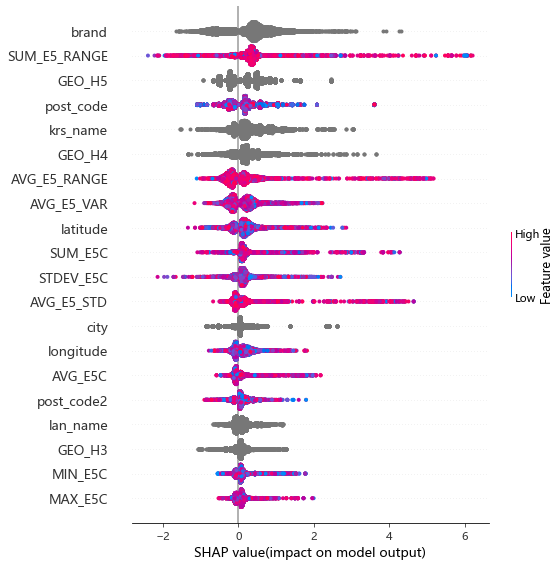

In [344]:
import pydotplus
import graphviz
from hana_ml.visualizers.model_debriefing import TreeModelDebriefing

shapley_explainer = TreeModelDebriefing.shapley_explainer(pred_res, gas_station_class_base, key='uuid', label='STATION_CLASS')
shapley_explainer.summary_plot()

In [ ]:
shapley_explainer = TreeModelDebriefing.shapley_explainer(pred_res.head(5), gas_station_class_base, key='uuid', label='STATION_CLASS')
shapley_explainer.force_plot()

In [ ]:
# Save Models and Model Quality Information to MLLAB-Sandbox
from hana_ml.model_storage import ModelStorage

MLLAB_models = ModelStorage(connection_context=conn)

hgbc.name = 'FUEL STATION PRICE-CLASS CLASSIFICATION MODEL' 
hgbc.version = 1
MLLAB_models.save_model(model=hgbc)


In [355]:
from hana_ml.model_storage import ModelStorage
MLLAB_models = ModelStorage(connection_context=conn)

list_models = MLLAB_models.list_models()
print(list_models)

                                            NAME  VERSION LIBRARY  \
0  FUEL STATION PRICE-CLASS CLASSIFICATION MODEL        1     PAL   

                                                                 CLASS  \
0  hana_ml.algorithms.pal.unified_classification.UnifiedClassification   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [356]:
from hana_ml.visualizers.unified_report import UnifiedReport

mymodel = MLLAB_models.load_model('FUEL STATION PRICE-CLASS CLASSIFICATION MODEL', 1)
UnifiedReport(mymodel).build().display()

#UnifiedReport(hgbc).display()

In order to review the unified classification model report better, you need to adjust the size of the left area or hide the left area temporarily!


## more

### OSMX import german highways

In [360]:
german_highways = conn.sql('select * from "RAW_DATA"."GEO_GERMANY_HIGHWAYS"')
german_highways.head(3).collect()

ID                            osmid  \
0   1  [4067762, 268873244, 128272242]   
1   3                        128272241   
2   4                         23687263   

                                                                                                                                                                                                                                                                                                                                                                                                                            geometry_GEO  \
0  LINESTRING (10.3048435 47.680641, 10.3046539 47.6806941, 10.3040756 47.6807097, 10.3036267 47.6807713, 10.3034295 47.6808141, 10.3032758 47.6808724, 10.3031509 47.680947, 10.3030899 47.6810296, 10.3030635 47.6811507, 10.3030844 47.6812908, 10.3031781 47.6813872, 10.3032677 47.6814455, 10.303431 47.6815213, 10.3036393 47.681586, 10.3039103 47.6816372, 10.3041635 47.6816429, 10.3044902 47.6816217, 10.3047585 47.6815808)   
1                                                                                                                                                                                                                                                                                   LINESTRING (10.3047585 47.6815808, 10.3049173 47.681474, 10.3049807 47.6814109, 10.3050307 47.6813502, 10.3050388 47.6812528, 10.3050812 47.6811333)   
2                                                                                                                                                                                                                                                                                                                                LINESTRING (10.3045418 47.6796142, 10.3047114 47.6795546, 10.3048943 47.6795319, 10.3051732 47.6794973)   

         highway  ref  
0  motorway_link  nan  
1  motorway_link  nan  
2  motorway_link  nan

### OSMX import RNK highways

In [371]:
print(stations_spatial.columns)
stations_spatial.head(1).drop('SHAPE').collect()

['uuid', 'longitude', 'latitude', 'longitude_latitude_GEO', 'GEO_H3', 'GEO_H4', 'GEO_H5', 'GEO_H6', 'GEO_H7', 'lan_name', 'krs_name', 'krs_type', 'SHAPE']


uuid  longitude  latitude  \
0  339bc8da-c797-46d7-93f1-fe3461397bf0  12.157612  49.66278   

       longitude_latitude_GEO GEO_H3 GEO_H4 GEO_H5  GEO_H6   GEO_H7 lan_name  \
0  POINT (12.157612 49.66278)    u2b   u2bd  u2bds  u2bds8  u2bds8u   Bayern   

                            krs_name          krs_type  
0  Kreisfreie Stadt Weiden i.d. OPf.  Kreisfreie Stadt

In [400]:
# Aggregate 3 Landkreis-Regions
RNKarea_hdf=stations_spatial.filter(
    "\"krs_name\"='Landkreis Rhein-Neckar-Kreis' or \"krs_name\"='Stadtkreis Heidelberg' or \"krs_name\"='Stadtkreis Mannheim'"
     ).select(('ST_UnionAggr(SHAPE).ST_SRID(4326)','SHAPE'))
RNKarea_hdf.collect()

SHAPE
0  (POLYGON ((9.086158752441406 49.50007629394531, 9.085700988769531 49.50064086914062, 9.083488464355469 49.50254058837891, 9.082923889160156 49.50308227539062, 9.082237243652344 49.50423431396484, 9.081489562988281 49.50482177734375, 9.079925537109375 49.50568389892578, 9.079338073730469 49.50640869140625, 9.0777587890625 49.50749206542969, 9.076217651367188 49.50820922851562, 9.074493408203125 49.50868225097656, 9.072837829589844 49.50885009765625, 9.071540832519531 49.50883483886719, 9.070152282714844 49.50868225097656, 9.070579528808594 49.50962829589844, 9.073143005371094 49.51354217529297, 9.076278686523438 49.52191925048828, 9.077056884765625 49.52312469482422, 9.082260131835938 49.52302551269531, 9.083900451660156 49.52629089355469, 9.078857421875 49.52494049072266, 9.074226379394531 49.52626800537109, 9.069717407226562 49.52694702148438, 9.066574096679688 49.52897644042969, 9.064949035644531 49.52960968017578, 9.064056396484375 49.52900695800781, 9.062828063964844 49.52803802490234, 9.061141967773438 49.52658081054688, 9.060028076171875 49.52555084228516, 9.057609558105469 49.52321624755859, 9.056571960449219 49.52235412597656, 9.055511474609375 49.52165222167969, 9.055076599121094 49.521484375, 9.053848266601562 49.52120208740234, 9.051483154296875 49.52059936523438, 9.050552368164062 49.52006530761719, 9.049949645996094 49.51937103271484, 9.049400329589844 49.51826477050781, 9.04901123046875 49.51663970947266, 9.049186706542969 49.5155029296875, 9.049591064453125 49.51428985595703, 9.049575805664062 49.51364898681641, 9.048873901367188 49.51264190673828, 9.048194885253906 49.51215362548828, 9.047927856445312 49.51139068603516, 9.047409057617188 49.51045227050781, 9.044326782226562 49.50813293457031, 9.043434143066406 49.50762176513672, 9.042533874511719 49.5069580078125, 9.042182922363281 49.50651550292969, 9.042091369628906 49.50587463378906, 9.0421142578125 49.504638671875, 9.042320251464844 49.50330352783203, 9.042549133300781 49.50267791748047, 9.042549133300781 49.5015869140625, 9.041252136230469 49.49995422363281, 9.040756225585938 49.49906921386719, 9.038429260253906 49.49909973144531, 9.036575317382812 49.49900054931641, 9.035911560058594 49.49887847900391, 9.032875061035156 49.49852752685547, 9.030166625976562 49.49826812744141, 9.02716064453125 49.49813079833984, 9.025665283203125 49.4981689453125, 9.023826599121094 49.49799346923828, 9.022689819335938 49.49797821044922, 9.020523071289062 49.49802398681641, 9.017669677734375 49.49775695800781, 9.016029357910156 49.49777984619141, 9.014236450195312 49.49806213378906, 9.013084411621094 49.49842071533203, 9.012603759765625 49.49874114990234, 9.012504577636719 49.49908447265625, 9.012901306152344 49.49983215332031, 9.013519287109375 49.50038909912109, 9.013717651367188 49.50074005126953, 9.013572692871094 49.50141906738281, 9.012977600097656 49.50181579589844, 9.012176513671875 49.50267028808594, 9.010772705078125 49.50228881835938, 9.008171081542969 49.50234222412109, 9.005081176757812 49.50418090820312, 9.002525329589844 49.50435638427734, 8.999542236328125 49.50438690185547, 8.997772216796875 49.50489807128906, 8.992256164550781 49.50338745117188, 8.987579345703125 49.50569152832031, 8.985832214355469 49.51033020019531, 8.981826782226562 49.50987243652344, 8.979171752929688 49.50917816162109, 8.977767944335938 49.50796508789062, 8.9774169921875 49.50537109375, 8.976593017578125 49.50485992431641, 8.977470397949219 49.50341796875, 8.974922180175781 49.5032958984375, 8.968002319335938 49.50160217285156, 8.965019226074219 49.50179290771484, 8.963493347167969 49.50148010253906, 8.960762023925781 49.50242614746094, 8.958747863769531 49.50291442871094, 8.951835632324219 49.50562286376953, 8.951225280761719 49.50270843505859, 8.954109191894531 49.50014495849609, 8.957725524902344 49.4954833984375, 8.955223083496094 49.49300384521484, 8.951988220214844 49.49172973632812, 8.951553344726562 49.49077606201172, 8.951713562011719 49.48917388916016, 8.950599670410

In [401]:
print(RNKarea_hdf.select_statement)

SELECT ST_UnionAggr(SHAPE).ST_SRID(4326) AS "SHAPE" FROM (SELECT * FROM (SELECT * FROM (SELECT "uuid", "longitude", "latitude", "longitude_latitude_GEO", "GEOHASH_HIERARCHY(longitude_latitude_GEO,3)" AS "GEO_H3", "GEOHASH_HIERARCHY(longitude_latitude_GEO,4)" AS "GEO_H4", "GEOHASH_HIERARCHY(longitude_latitude_GEO,5)" AS "GEO_H5", "GEOHASH_HIERARCHY(longitude_latitude_GEO,6)" AS "GEO_H6", "GEOHASH_HIERARCHY(longitude_latitude_GEO,7)" AS "GEO_H7" FROM (SELECT *, "longitude_latitude_GEO".ST_GeoHash(3) AS "GEOHASH_HIERARCHY(longitude_latitude_GEO,3)", "longitude_latitude_GEO".ST_GeoHash(4) AS "GEOHASH_HIERARCHY(longitude_latitude_GEO,4)", "longitude_latitude_GEO".ST_GeoHash(5) AS "GEOHASH_HIERARCHY(longitude_latitude_GEO,5)", "longitude_latitude_GEO".ST_GeoHash(6) AS "GEOHASH_HIERARCHY(longitude_latitude_GEO,6)", "longitude_latitude_GEO".ST_GeoHash(7) AS "GEOHASH_HIERARCHY(longitude_latitude_GEO,7)" FROM (SELECT "uuid", "longitude", "latitude", "longitude_latitude_GEO" FROM (SELECT "uuid", 

In [376]:
# Create HANA dataframe with spatial attributes    
hdf_RNK_SHAPE = stations_spatial.filter("\"krs_name\"='Landkreis Rhein-Neckar-Kreis'" ).select('uuid','krs_name', 'SHAPE').head(1)
#print(hdf_RNK_SHAPE.dtypes())
hdf_RNK_SHAPE.drop('SHAPE').collect()
#111 uuids, but we need jus 1

uuid                      krs_name
0  00817d75-635d-4f2a-a556-4135ef42666e  Landkreis Rhein-Neckar-Kreis

In [377]:
# Create Geopandas Dataframe from the HANA dataframe
gdf2 = gpd.GeoDataFrame(hdf_RNK_SHAPE.select('uuid', 'SHAPE').collect(), geometry='SHAPE')
gdf2=gdf2.rename_geometry('geometry')
gdf2.head(10)

uuid  \
0  00817d75-635d-4f2a-a556-4135ef42666e   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [147]:
import osmnx as ox              # open streets networks sets

In [179]:
%%time
# get pois from OSMNX query
# gdf_geoms = ox.geometries.geometries_from_polygon(
#    gdf2['geometry'][0], 
#    {'highway': ['motorway', 'primary', 'secondary']})


Wall time: 1min 10s


In [196]:
%%time
ox.config(use_cache=True, log_console=True)
#cf = '["highway"~"motorway|motorway_link|primary|secondary"]'
cf = '["highway"~"motorway|primary|secondary"]'
g = ox.graph_from_polygon(polygon = gdf2['geometry'][0], network_type = 'drive',custom_filter=cf)
#fig, ax = ox.plot_graph(g, fig_height=5)

In [197]:
g

C:\Users\D059078\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
C:\Users\D059078\AppData\Local\Continuum\anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


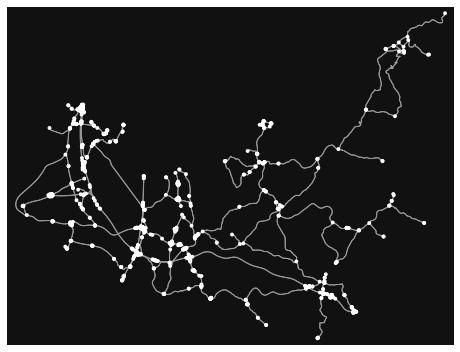

In [198]:
fig, ax = ox.plot_graph(g)

In [188]:
gdf_nodes,gdf_edges = ox.graph_to_gdfs(g, nodes=True, edges=True)

In [ ]:
gdf_edges.head(1)

In [ ]:
pandas_df2=pd.DataFrame(gdf_edges, copy=True)[['osmid', 'geometry', 'highway','ref']]
#pandas_df2=pd.DataFrame(gdf_edges, copy=True)[['geometry', 'highway','ref']]
pandas_df2

In [ ]:
%%time
# Create a dataframe of the amenities 
from hana_ml.dataframe import create_dataframe_from_pandas
## (4326) 28355

hdf3 = create_dataframe_from_pandas(
    connection_context=conn, replace=True,
    pandas_df=pandas_df2,
    geo_cols=['geometry'], srid=4326,
    schema='TECHED_USER_999',
    table_name="RNK_GEOMETRIES"
    , drop_exist_tab=True, force=True)

In [ ]:
hdf3.head(3).collect()

### Add spatial distance attributes

In [ ]:
stations_A5dist=conn.sql(
"""
SELECT "uuid", "STATION_P", A5.STREET_LINE, ("STATION_P".ST_SRID(1000004326).ST_DISTANCE(STREET_LINE.ST_SRID(1000004326), \'meter\')) AS DIST_A5
from
(SELECT "uuid", "longitude_latitude_GEO".ST_SRID(4326) AS "STATION_P" 
   FROM (SELECT S."uuid", "longitude_latitude_GEO"
         from TECHED_USER_999.STATION_PRICECLASSIFICATION S, TECHED_USER_999.GAS_STATIONS G
         WHERE S."krs_name" =  \'Landkreis Rhein-Neckar-Kreis\' AND S."uuid"=G."uuid"
         ) AS P
    ),
(SELECT "highway", "ref", NEW ST_MultiLineString(\'MultiLineString (\' || substring(LSTRING,3) || \')\', 4326) AS STREET_LINE
  FROM (
       SELECT "highway", "ref", 
       replace(agg , \'SRID=4326;LINESTRING \', \', \') AS LSTRING
  FROM (
             SELECT "highway", "ref", STRING_AGG("geometry_GEO") AS agg 
             FROM RAW_DATA.GEO_RNK_HIGHWAYS 
             WHERE "ref" in (\'A 5\') AND NOT ("highway"=\'motorway_link\')
             GROUP BY "highway", "ref"
             )
        )
 ) AS A5;
"""
)
stations_A5dist.head(3).collect()

In [394]:
gas_station_spatial_att = conn.sql('SELECT "uuid", "DIST_A5" FROM TECHED_USER_999.GAS_STATIONS_SPATIAL_DISTANCE');
gas_station_spatial_att.head(5).collect()

uuid       DIST_A5
0  64b73478-c9fc-4829-a895-84840c02549a  10440.450740
1  7859c737-7ba0-4506-9ebd-867609d63371   8517.540722
2  7f3ceea1-1ee8-49d8-996d-632106b036d7  20486.557794
3  0e5f8257-c5e6-44f2-8d7f-4ba90f7b9646  14573.793914
4  1507cfcb-802b-4e55-a617-888c6c32df1a  22147.825104

# Appendix

## still needed for internal prep

 Create CSVs for train, test and ground truth

In [24]:
# in order to predict the last 7 days, we restict our training data to be earlier than 2022-06-14
train_rnk_trunc_hdf  = train_rnk_hdf.filter('"date" < \'2022-06-14 00:00:00.000\'')

In [25]:
# ground truth
test_groundtruth_rnk_hdf  = train_rnk_hdf.filter('"date" >= \'2022-06-14 00:00:00.000\'')

In [26]:
# create test dataset, same as ground truth only target column values set to 0
test_rnk_hdf = test_groundtruth_rnk_hdf.drop(['e5'])
test_rnk_hdf = test_rnk_hdf.add_constant('e5', 0)
test_rnk_hdf = test_rnk_hdf.cast('e5', 'DOUBLE')

In [27]:
test_groundtruth_rnk_hdf.head(3).collect()

date                          station_uuid     e5
0 2022-06-17 09:31:07  e1e4230d-98d0-433b-ad28-bf673862592f  2.019
1 2022-06-18 07:01:08  66f17d7a-2572-4c7a-81a3-91da096629cd  2.029
2 2022-06-18 07:01:08  c0bc562d-d77f-440e-9182-57654145275c  2.009

In [ ]:
# create csv files
test_gt_rnk_pd = test_groundtruth_rnk_hdf.collect()
test_gt_rnk_pd.to_csv('test_groundtruth.csv')

test_rnk_pd = test_rnk_hdf.collect()
test_rnk_pd.to_csv('test_rnk.csv')

train_rnk_pd = train_rnk_trunc_hdf.collect()
train_rnk_pd.to_csv('train_rnk.csv')

## don't need this anymore

In [ ]:
# Show column descriptive statistics using the describe method
fuelprice_all_hdf.describe().head(10).collect()
# need 3, 5 and 95, 97  percentiles

In [ ]:
# Since the dataset contains the prices for all the service stations in Germany, 
# we filter out the records for the gas prices for the service stations in Rhein-Neckar area only

fuelprice_rnk_hdf = fuelprice_all_hdf.alias('L').join(stations_rnk_hdf.alias('R'), 'L."station_uuid" = R."uuid"', select = [
    ('L."date"', 'date'),
    ('L."station_uuid"', 'station_uuid'),
    ('L."e5"', 'e5')
])

In [ ]:
conn.sql_tracer.enable_sql_trace(True)
conn.sql_tracer.enable_trace_history(True)

In [ ]:
#New - Support for multi-line SQL
#df = conn.sql('SELECT "date", "station_uuid", "e5" from TECHED_DEV_D059078.TRAIN_RNK')
df = conn.sql('SELECT "station_uuid", max("e5") as MAX_E5  from TECHED_USER_999.TRAIN_RNK group by "station_uuid" order by MAX_E5 desc')
#df = conn.sql('SELECT "station_uuid", PERCENTILE_CONT(0.875) WITHIN GROUP (ORDER BY "e5") OVER (PARTITION BY "station_uuid") AS pc3 from TECHED_DEV_D059078.TRAIN_RNK')
df.collect()

## Plot predicted fuel prices for a couple of service station

In [26]:
# load the results into a pandas dataframe for plotting
result_pd = result[0].collect()

In [27]:
# load gas station data from csv
stations_pd = pd.read_csv('./datasets/stations.csv', sep=',', header=None, skiprows=1,
                          names=["uuid","name", "brand", "street","house_number",
                                  "post_code", "city", "latitude", "longitude"])

In [28]:
# 938c082c-e2c6-4292-8b2c-cdf83036e555 AVIA
# 9706790d-b179-426b-99ea-2d7346241ca9 Oili
station1 = stations_pd[stations_pd['uuid']=="018e8f3e-ae2f-40bc-89c1-bc3fe20eb462"] #Mülhausen
station2 = stations_pd[stations_pd['uuid']=="938c082c-e2c6-4292-8b2c-cdf83036e555"] #Walldorf AVIA
station3 = stations_pd[stations_pd['uuid']=="9706790d-b179-426b-99ea-2d7346241ca9"] #Walldorf Oili

In [29]:
# 
to_plot2_pd = train_rnk_hdf.filter('"station_uuid" =\'938c082c-e2c6-4292-8b2c-cdf83036e555\'').collect()
to_plot3_pd = train_rnk_hdf.filter('"station_uuid" =\'9706790d-b179-426b-99ea-2d7346241ca9\'').collect()

In [30]:
to_plot2_gt_pd = test_gt_rnk_hdf.filter('"station_uuid" =\'938c082c-e2c6-4292-8b2c-cdf83036e555\'').sort('date').collect()
to_plot3_gt_pd = test_gt_rnk_hdf.filter('"station_uuid" =\'9706790d-b179-426b-99ea-2d7346241ca9\'').sort('date').collect()

In [31]:
to_plot2_pred_pd = result_pd[result_pd['GROUP_ID']=="938c082c-e2c6-4292-8b2c-cdf83036e555"]
to_plot3_pred_pd = result_pd[result_pd['GROUP_ID']=="9706790d-b179-426b-99ea-2d7346241ca9"]

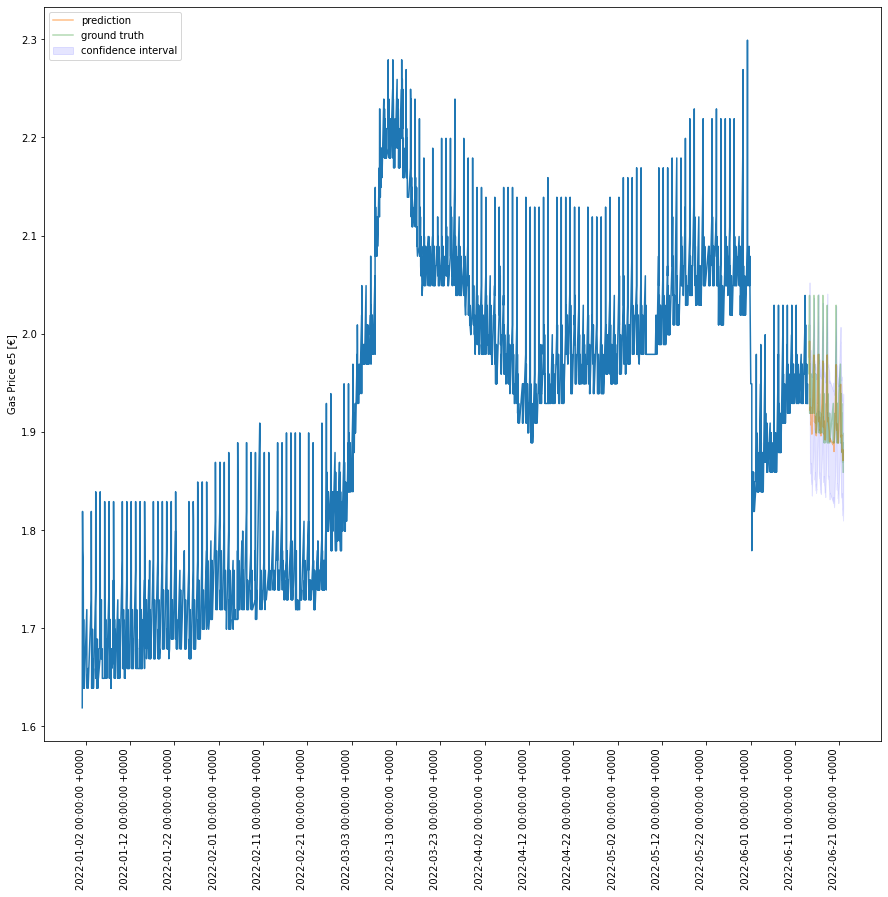

In [32]:
from matplotlib.pyplot import figure
import matplotlib.dates as mdates
figure(figsize=(15, 15))

to_plot2_pd = to_plot2_pd.sort_values('date', ascending=True)
to_plot2_pd['date'] = pd.to_datetime(to_plot2_pd['date'],  utc=True)

#to_plot3_pd = to_plot3_pd.sort_values('date', ascending=True)
#to_plot3_pd['date'] = pd.to_datetime(to_plot3_pd['date'],  utc=True)

ax = plt.gca()
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S %z'))  #'%Y-%m-%d %H:%M:%S.%f %z %Z'
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))

plt.gcf().autofmt_xdate(rotation=90)


#plt.plot(to_plot2_pd['date'], to_plot2_pd['e5'], label='AVIA' )
plt.plot(to_plot2_pd['date'], to_plot2_pd['e5'])
plt.plot(to_plot2_pred_pd['date'], to_plot2_pred_pd['YHAT'], label='prediction', alpha=.5 )
plt.plot(to_plot2_gt_pd['date'], to_plot2_gt_pd['e5'], c='green', alpha=0.3, label='ground truth' )
plt.fill_between(to_plot2_pred_pd['date'], to_plot2_pred_pd['YHAT_LOWER'], to_plot2_pred_pd['YHAT_UPPER'], color='b', alpha=.1, label= 'confidence interval')
plt.legend(loc="upper left")
plt.ylabel('Gas Price e5 [€]')
plt.show()

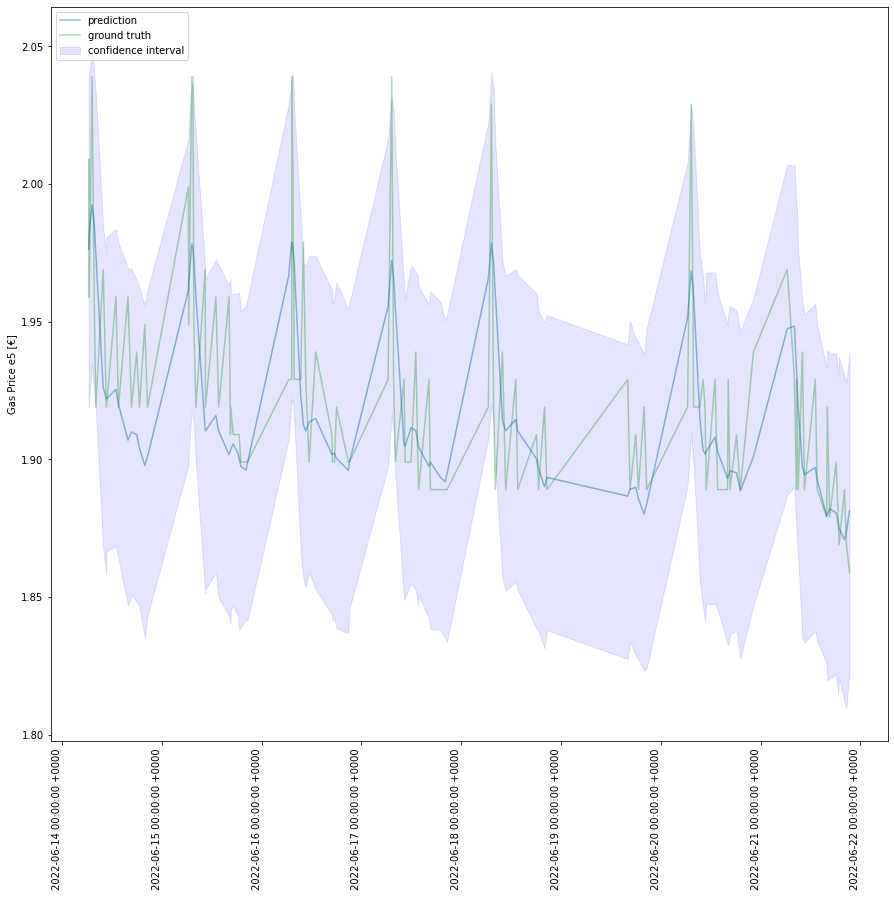

In [33]:
# let's look at the predicted values only
figure(figsize=(15, 15))

to_plot2_pd = to_plot2_pd.sort_values('date', ascending=True)
to_plot2_pd['date'] = pd.to_datetime(to_plot2_pd['date'],  utc=True)

ax = plt.gca()
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S %z'))  #'%Y-%m-%d %H:%M:%S.%f %z %Z'
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))

plt.gcf().autofmt_xdate(rotation=90)


#plt.plot(to_plot2_pd['date'], to_plot2_pd['e5'], label='AVIA' )
#plt.plot(to_plot3_pd['date'], to_plot3_pd['e5'])
plt.plot(to_plot2_pred_pd['date'], to_plot2_pred_pd['YHAT'], label='prediction', alpha=.5 )
plt.plot(to_plot2_gt_pd['date'], to_plot2_gt_pd['e5'], c='green', alpha=0.3, label='ground truth' )
plt.fill_between(to_plot2_pred_pd['date'], to_plot2_pred_pd['YHAT_LOWER'], to_plot2_pred_pd['YHAT_UPPER'], color='b', alpha=.1, label= 'confidence interval')
plt.legend(loc="upper left")
plt.ylabel('Gas Price e5 [€]')
plt.show()

## artefact generatio

In [33]:
from hana_ml.artifacts.generators import hana

In [34]:
hg = hana.HanaGenerator(project_name="AdditiveModel", version='1', grant_service='',
                        connection_context=conn, outputdir="./hana_hdi")

In [35]:
hg.generate_artifacts()

'./hana_hdi/AdditiveModel/hana'

In [38]:
!ls hana_hdi/AdditiveModel/hana/AdditiveModel/src/procedures/

base_additivemodelforecast1_fit.hdbprocedure
base_additivemodelforecast2_fit.hdbprocedure
base_additivemodelforecast2_predict.hdbprocedure
cons_base_additivemodelforecast1_fit.hdbprocedure
cons_base_additivemodelforecast2_fit.hdbprocedure
cons_base_additivemodelforecast2_predict.hdbprocedure


In [42]:
!cat hana_hdi/AdditiveModel/hana/AdditiveModel/src/procedures/base_additivemodelforecast2_fit.hdbprocedure

PROCEDURE base_additivemodelforecast2_fit(in lt_in_0_additivemodelforecast2_fit table ("station_uuid" NVARCHAR(5000),"date" TIMESTAMP,"e5" DOUBLE), in lt_model_in_1_additivemodelforecast2_fit table ("GROUP_IDXXX" INT,"ts" TIMESTAMP,"NAME" NVARCHAR(255),"LOWER_WINDOW" INT,"UPPER_WINDOW" INT), out lt_model_out_0_additivemodelforecast2_fit table ("GROUP_ID" NVARCHAR(100),"ROW_INDEX" INT,"MODEL_CONTENT" NCLOB), out lt_model_out_1_additivemodelforecast2_fit table ("GROUP_ID" NVARCHAR(100),"ERROR_TIMESTAMP" NVARCHAR(100),"ERRORCODE" INT,"MESSAGE" NVARCHAR(200)))
    LANGUAGE SQLSCRIPT
    SQL SECURITY INVOKER
    AS
BEGIN
DECLARE group_id NVARCHAR(100) ARRAY;
DECLARE param_name VARCHAR(5000) ARRAY;
DECLARE int_value INTEGER ARRAY;
DECLARE double_value DOUBLE ARRAY;
DECLARE string_value VARCHAR(5000) ARRAY;
in_1 = SELECT * FROM :lt_model_in_1_additivemodelforecast2_fit;
in_0 = SELECT * FROM :lt_in_0_additivemodelforecast2_fit;
group_id[1] := N'PAL_MASSIVE_PROCESSING_SPECIAL_GROUP_ID';
param_n

In [44]:
!cat hana_hdi/AdditiveModel/hana/AdditiveModel/src/procedures/base_additivemodelforecast2_predict.hdbprocedure

PROCEDURE base_additivemodelforecast2_predict(in lt_in_0_additivemodelforecast2_predict table ("station_uuid" NVARCHAR(50),"date" TIMESTAMP,"e5" DOUBLE), in lt_model_in_1_additivemodelforecast2_predict table ("GROUP_ID" NVARCHAR(100),"ROW_INDEX" INT,"MODEL_CONTENT" NCLOB), out lt_model_out_0_additivemodelforecast2_predict table ("GROUP_ID" NVARCHAR(100),"date" TIMESTAMP,"YHAT" DOUBLE,"YHAT_LOWER" DOUBLE,"YHAT_UPPER" DOUBLE), out lt_model_out_1_additivemodelforecast2_predict table ("GROUP_ID" NVARCHAR(100),"date" TIMESTAMP,"TREND" DOUBLE,"SEASONAL" NCLOB,"HOLIDAY" NCLOB,"EXOGENOUS" NCLOB), out lt_model_out_1_additivemodelforecast2_predict table ("GROUP_ID" NVARCHAR(100),"date" TIMESTAMP,"TREND" DOUBLE,"SEASONAL" NCLOB,"HOLIDAY" NCLOB,"EXOGENOUS" NCLOB), out lt_model_out_2_additivemodelforecast2_predict table ("GROUP_ID" NVARCHAR(100),"ERROR_TIMESTAMP" NVARCHAR(100),"ERRORCODE" INT,"MESSAGE" NVARCHAR(200)), out lt_model_out_2_additivemodelforecast2_predict table ("GROUP_ID" NVARCHAR(100)

## autoML for TimeSeries

In [247]:

# 9706790d-b179-426b-99ea-2d7346241ca9 Oili
#filter("\"lan_name\"='Baden-Württemberg'")
train_rnk_hdf2=train_rnk_hdf.filter("\"station_uuid\"='9706790d-b179-426b-99ea-2d7346241ca9'")
train_rnk_hdf2=train_rnk_hdf2.drop('station_uuid')
train_rnk_hdf2=train_rnk_hdf2.sort('date', desc=False)
train_rnk_hdf2.head(10).collect()

In [248]:


from hana_ml.algorithms.pal.auto_ml import AutomaticTimeSeries
from hana_ml.visualizers.automl_progress import PipelineProgressStatusMonitor

model = AutomaticTimeSeries(early_stop=10, scorings={'RMSE': -1})
progress_status_monitor = PipelineProgressStatusMonitor(conn, automatic_obj=model)

progress_status_monitor.start()

model.disable_workload_class_check()
model.fit(train_rnk_hdf2, key="date")


<IPython.core.display.Javascript object>

ERROR:hana_ml.algorithms.pal.auto_ml:(139, 'current operation cancelled by request and transaction rolled back: "TECHED_ADMIN"."(DO statement)": line 37 col 1 (at pos 2491): ')
Traceback (most recent call last):
  File "C:\Users\D059078\AppData\Local\Continuum\anaconda3\lib\site-packages\hana_ml\algorithms\pal\auto_ml.py", line 409, in fit
    *outputs)
  File "C:\Users\D059078\AppData\Local\Continuum\anaconda3\lib\site-packages\hana_ml\algorithms\pal\pal_base.py", line 819, in _call_pal_auto
    *_args)
  File "C:\Users\D059078\AppData\Local\Continuum\anaconda3\lib\site-packages\hana_ml\algorithms\pal\pal_base.py", line 1214, in call_pal_auto_with_hint
    if try_exec(cur, sql, conn):
  File "C:\Users\D059078\AppData\Local\Continuum\anaconda3\lib\site-packages\hana_ml\algorithms\pal\pal_base.py", line 1174, in try_exec
    cur.execute(sql)
hdbcli.dbapi.InternalError: (139, 'current operation cancelled by request and transaction rolled back: "TECHED_ADMIN"."(DO statement)": line 37 col

InternalError: (139, 'current operation cancelled by request and transaction rolled back: "TECHED_ADMIN"."(DO statement)": line 37 col 1 (at pos 2491): ')

In [249]:
model.best_pipeline_.collect()

AttributeError: 'AutomaticTimeSeries' object has no attribute 'best_pipeline_'

In [8]:
from hana_ml.visualizers.automl_report import BestPipelineReport
BestPipelineReport(model).generate_notebook_iframe()

In [9]:
predict_frame = model.make_future_dataframe(periods=10)

In [11]:
result = model.predict(predict_frame, key="date")
result.collect()

ERROR:hana_ml.algorithms.pal.auto_ml:(423, 'AFL error: "TECHED_ADMIN"."(DO statement)": line 9 col 1 (at pos 1384): search table error: _SYS_AFL.AFLPAL:PIPELINE_PREDICT: [423] (range 3) AFL error exception: exception 73001007: Invalid table:$TAB$.. \n')
Traceback (most recent call last):
  File "C:\Users\D059078\AppData\Local\Continuum\anaconda3\lib\site-packages\hana_ml\algorithms\pal\auto_ml.py", line 513, in predict
    *outputs)
  File "C:\Users\D059078\AppData\Local\Continuum\anaconda3\lib\site-packages\hana_ml\algorithms\pal\pal_base.py", line 819, in _call_pal_auto
    *_args)
  File "C:\Users\D059078\AppData\Local\Continuum\anaconda3\lib\site-packages\hana_ml\algorithms\pal\pal_base.py", line 1214, in call_pal_auto_with_hint
    if try_exec(cur, sql, conn):
  File "C:\Users\D059078\AppData\Local\Continuum\anaconda3\lib\site-packages\hana_ml\algorithms\pal\pal_base.py", line 1174, in try_exec
    cur.execute(sql)
hdbcli.dbapi.Error: (423, 'AFL error: "TECHED_ADMIN"."(DO statemen

Error: (423, 'AFL error: "TECHED_ADMIN"."(DO statement)": line 9 col 1 (at pos 1384): search table error: _SYS_AFL.AFLPAL:PIPELINE_PREDICT: [423] (range 3) AFL error exception: exception 73001007: Invalid table:$TAB$.. \n')